# YOLACT Google Colab Notebook
Inference on images and video with [YOLACT](https://github.com/dbolya/yolact).

## Google Colab
This notebook is set up to work inside Google Colab, which is a free, Linux-based Jupyter Notebook environment hosted in the cloud.

If you try it outside of Google Colab I'm not sure if it will work. I originally had problems running locally on my Windows machine, which is why I switched to this.

### Runtime Setup
- Go to Runtime > Change Runtime Type
- Choose GPU (TPU won't work)

## YOLACT
YOLACT is a state of the art, real-time, single shot object segmentation algorithm detailed in these papers:  
- [YOLACT: Real-time Instance Segmentation](https://arxiv.org/abs/1904.02689)
- [YOLACT++: Better Real-time Instance Segmentation](https://arxiv.org/abs/1912.06218)

**Big thanks to the authors: Daniel Bolya, Chong Zhou, Fanyi Xiao, Yong Jae Lee!**

## Immersive Limit
This notebook was created by Adam Kelly, instructor/creator of [immersivelimit.com](https://www.immersivelimit.com).
- Subscribe for lots more awesome AI and 3D content on the [YouTube channel](https://www.youtube.com/c/immersivelimit)
- Check out https://www.immersivelimit.com/connect for more ways to follow/connect 😀

In [1]:
!nvidia-smi

Sat Sep  5 10:26:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Initial Setup
First, we install some Python libraries. Google Colab probably has these requirements already, but better to include them than to break later.

In [3]:
# Cython needs to be installed before pycocotools
!pip install cython
!pip install opencv-python pillow pycocotools matplotlib

In [4]:
# Downgrade torch to accommodate DCNv2
!pip install torchvision==0.5.0
!pip install torch==1.4.0


     |████████████████████████████████| 4.0MB 5.5MB/s 
     |████████████████████████████████| 753.4MB 18kB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


## Clone YOLACT from GitHub
Let's get that github repo! If anything in this notebook breaks, check the repo in case they've made updates.

In [5]:
# Make sure we're in the top folder
%cd /content

# Clone the repo
!git clone https://github.com/dbolya/yolact.git

/content
Cloning into 'yolact'...
remote: Enumerating objects: 2933, done.
remote: Total 2933 (delta 0), reused 0 (delta 0), pack-reused 2933
Receiving objects: 100% (2933/2933), 21.20 MiB | 34.73 MiB/s, done.
Resolving deltas: 100% (2000/2000), done.


## DCNv2
The DCNv2 external library is needed for this to work, so we'll build it now.

**IF YOU GET CUDA ERRORS** You need to change the Runtime of this notebook to "GPU" as mentioned at the top of the notebook.

In [6]:
# Change to the right directory
%cd /content/yolact/external/DCNv2

# Build DCNv2
!python setup.py build develop

/content/yolact/external/DCNv2
running build
running build_ext
building '_ext' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/content
creating build/temp.linux-x86_64-3.6/content/yolact
creating build/temp.linux-x86_64-3.6/content/yolact/external
creating build/temp.linux-x86_64-3.6/content/yolact/external/DCNv2
creating build/temp.linux-x86_64-3.6/content/yolact/external/DCNv2/src
creating build/temp.linux-x86_64-3.6/content/yolact/external/DCNv2/src/cpu
creating build/temp.linux-x86_64-3.6/content/yolact/external/DCNv2/src/cuda
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -DWITH_CUDA -I/content/yolact/external/DCNv2/src -I/usr/local/lib/python3.6/dist-packages/torch/include -I/usr/local/lib/python3.6/dist-packages/torch/include/torch/csrc/api/include -I/usr/local/lib/python3.6/dist-packages/torch/include/TH -I/usr/local/

## Pretrained Weights
In order to run inference, we'll need some pre-trained weights. The creator of the GitHub repo shared them on Google Drive. We're going to use a [helpful tool](https://github.com/chentinghao/download_google_drive) made by [chentinghao](https://github.com/chentinghao) to easily access the Drive file from Colab.

If this stops working, it's probably because the weights moved to a different location. Check the YOLACT github repo to see where they went.

In [7]:
# Make sure we're in the top folder
%cd /content

# Clone the repo
!git clone https://github.com/chentinghao/download_google_drive.git

# Create a new directory for the pre-trained weights
!mkdir -p "/content/drive/My Drive/YOLACT/weights"
!ln -s "/content/drive/My Drive/YOLACT/weights" ./yolact/weights
#!mkdir -p /content/yolact/weights

# Download the file
!python ./download_google_drive/download_gdrive.py 1ZPu1YR2UzGHQD0o1rEqy-j5bmEm3lbyP ./yolact/weights/yolact_plus_resnet50_54_800000.pth

/content
Cloning into 'download_google_drive'...
remote: Enumerating objects: 16, done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 16
Unpacking objects: 100% (16/16), done.
129MB [00:00, 169MB/s]


In [8]:
%cd /content

# Download the file
!python ./download_google_drive/download_gdrive.py 1Jy3yCdbatgXa5YYIdTCRrSV0S9V5g1rn ./yolact/weights/resnet50-19c8e357.pth

/content
97.8MB [00:01, 103MB/s] 


# Get Test Images
We'll download a few test images from the [COCO dataset](http://cocodataset.org/#explore). Feel free to try out your own images as well, but know that there are only 80 categories and they're not intended to cover everything, so if you upload a picture of a snake, a mouse, and a cat, only the cat will be detected.

In [9]:
# Make a new directory for the test images
!mkdir /content/test_images

# Move to the new directory
%cd /content/test_images

# Make a list of URLs from the COCO dataset
get_imgs = ['http://farm8.staticflickr.com/7200/6946559805_7edf757660_z.jpg',
            'http://farm3.staticflickr.com/2835/9520716824_51220b13d0_z.jpg',
            'http://farm3.staticflickr.com/2817/10105052924_0c8d79e62c_z.jpg',
            'https://farm3.staticflickr.com/2637/3679968895_37a79e55b3_z.jpg',
            'https://farm8.staticflickr.com/7137/7705349298_6bea29cf1c_z.jpg',
            'http://farm5.staticflickr.com/4105/4981945644_3f162314ed_z.jpg',
            'http://farm1.staticflickr.com/40/101757885_a8fc40e273_z.jpg',
            'http://farm3.staticflickr.com/2654/3897535041_fa8dd5570b_z.jpg']

# Download all the images
for img_url in get_imgs:
  !wget {img_url} -nc

# List the contents of the folder. Should have images.
!pwd
!ls

/content/test_images
--2020-09-05 10:31:42--  http://farm8.staticflickr.com/7200/6946559805_7edf757660_z.jpg
Resolving farm8.staticflickr.com (farm8.staticflickr.com)... 13.224.26.167, 2600:9000:2164:fc00:0:5a51:64c9:c681, 2600:9000:2164:4000:0:5a51:64c9:c681, ...
Connecting to farm8.staticflickr.com (farm8.staticflickr.com)|13.224.26.167|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://farm8.staticflickr.com/7200/6946559805_7edf757660_z.jpg [following]
--2020-09-05 10:31:42--  https://farm8.staticflickr.com/7200/6946559805_7edf757660_z.jpg
Connecting to farm8.staticflickr.com (farm8.staticflickr.com)|13.224.26.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘6946559805_7edf757660_z.jpg’

6946559805_7edf7576     [ <=>                ]  52.94K  --.-KB/s    in 0.01s   

2020-09-05 10:31:43 (5.34 MB/s) - ‘6946559805_7edf757660_z.jpg’ saved [54206]

--2020-09-05 10:31:43--  ht

# Run Inference on Images
Let's run inference. We do that with eval.py

In [10]:
# Move up to the top level directory
%cd /content

# Delete any previous output_images folder (in case we're running this more than once)
!rm /content/output_images -r

# Create a new directory for output images
!mkdir -p /content/output_images

# Run inference using our pre-trained weights on all images in the directory
!python ./yolact/eval.py --trained_model=./yolact/weights/yolact_plus_resnet50_54_800000.pth --config=yolact_plus_resnet50_config --score_threshold=0.15 --top_k=15 --images=test_images:output_images

/content
rm: cannot remove '/content/output_images': No such file or directory
Loading model... Done.

test_images/7705349298_6bea29cf1c_z.jpg -> output_images/7705349298_6bea29cf1c_z.png
test_images/3679968895_37a79e55b3_z.jpg -> output_images/3679968895_37a79e55b3_z.png
test_images/101757885_a8fc40e273_z.jpg -> output_images/101757885_a8fc40e273_z.png
test_images/6946559805_7edf757660_z.jpg -> output_images/6946559805_7edf757660_z.png
test_images/4981945644_3f162314ed_z.jpg -> output_images/4981945644_3f162314ed_z.png
test_images/9520716824_51220b13d0_z.jpg -> output_images/9520716824_51220b13d0_z.png
test_images/10105052924_0c8d79e62c_z.jpg -> output_images/10105052924_0c8d79e62c_z.png
test_images/3897535041_fa8dd5570b_z.jpg -> output_images/3897535041_fa8dd5570b_z.png
Done.


## Display Output Images
The last step saved output images, so we'll display those now.

In [11]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

output_images = Path('output_images')

def show_image(img_path):
  img = cv2.imread(img_path)
  img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(16,16))
  plt.imshow(img_cvt)
  plt.show()

# Iterate through all of the output images and display them
for img_path in output_images.iterdir():
  print(img_path)
  show_image(str(img_path))

Output hidden; open in https://colab.research.google.com to view.

# Run Inference on Video
I can't figure out how to get Google Colab to show the output video in the notebook, so I've uploaded the video to YouTube. The mask quality is incredible. There are some false positives because it thinks the rocks are sheep, but we'll give it a pass because it's never been told what a rock is before (COCO dataset doesn't contain rocks) and the rocks do look a bit sheepish.


In [12]:
#from IPython.display import HTML
#HTML('<iframe width="1280" height="720" src="https://www.youtube.com/embed/bQgtmbzN7jg" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

If you'd like to process your own video, you can modify the steps below.

In [13]:
## Make a new directory for the test images
#!mkdir -p /content/test_video
#
## Move to the top level directory
#%cd /content
#
## Download the file
## https://drive.google.com/file/d/1I4fivRLniVNt_LcWqhQNehTSdEkZ4ytW/view?usp=sharing
## Note that file_id is extracted from the share URL above, it'll be different for every file
#file_id = "1I4fivRLniVNt_LcWqhQNehTSdEkZ4ytW"
#file_path = "/content/test_video/giraffes_full_720.mp4" # <- this is the destination path
#
#!python /content/download_google_drive/download_gdrive.py {file_id} {file_path}
#
#!ls /content/test_video

Now we run inference.

In [14]:
#%cd /content
#!mkdir -p /content/output_videos
#output_path = "/content/output_videos/giraffes_full_720_output.mp4"
##!python ./yolact/eval.py --trained_model=./yolact/weights/yolact_plus_resnet50_54_800000.pth --score_threshold=0.15 --top_k=15 --video_multiframe=4 --video={file_path}:{output_path}
#!python ./yolact/eval.py --trained_model=./yolact/weights/yolact_plus_resnet50_54_800000.pth --score_threshold=0.15 --top_k=15 --video_multiframe=1 --video={file_path}:{output_path}

## Download the output file
In this part, we'll mount your Google Drive and you can copy the file somewhere over there. I tried using the google.colab.files library to download the file, but it doesn't seem to like big video files.

- You will need to authorize your Drive to connect, then it basically just links your drive as if it's a folder on this cloud computer.
- **Be careful** because if you start deleting/modifying files in this folder, you will modify your personal Google Drive.


In [15]:
#from google.colab import drive
#drive.mount('/content/drive')

In [16]:
#!mkdir -p /content/drive/My\ Drive/YOLACT_output
#%cd /content/drive/My\ Drive/YOLACT_output
#!ls

In [17]:
#!cp {output_path} /content/drive/My\ Drive/YOLACT_output/giraffes_full_720_output.mp4

## Find the Video on Google Drive
Now you should be able to view the file on your Google Drive in the YOLACT_output folder.

## [Fashionpedia Dataset](https://github.com/cvdfoundation/fashionpedia)

In [18]:
%cd /content/yolact/data

/content/yolact/data


In [19]:
!mkdir -p ifashionist-dataset

In [20]:
%cd ifashionist-dataset

/content/yolact/data/ifashionist-dataset


In [21]:
!wget https://s3.amazonaws.com/ifashionist-dataset/images/train2020.zip

--2020-09-05 10:31:57--  https://s3.amazonaws.com/ifashionist-dataset/images/train2020.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.85.229
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.85.229|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3344364592 (3.1G) [application/zip]
Saving to: ‘train2020.zip’

train2020.zip       100%[===================>]   3.11G  48.5MB/s    in 69s     

2020-09-05 10:33:07 (46.1 MB/s) - ‘train2020.zip’ saved [3344364592/3344364592]



In [22]:
!unzip train2020.zip

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: train/236f5f6a3d70aebe9807ee1cdb00a26a.jpg  
  inflating: train/bc3f324781cb94d7632fb449857645d5.jpg  
  inflating: train/febafb43e0a8a5a62bd64d0e1e2c51bb.jpg  
  inflating: train/62f7105882625f0ea9c43639cc450af2.jpg  
  inflating: train/bbaaed6a5643083d11db6c6839ce162c.jpg  
  inflating: train/1127d6d9a4ad34e3f6ea6abfed23fadf.jpg  
  inflating: train/dc8e143844a77f42337c7f6d1a83f0a9.jpg  
  inflating: train/2ab1eb6b641df05b18bbcd31546f41c3.jpg  
  inflating: train/39c5ccb6ae593374c065719c46b14cb7.jpg  
  inflating: train/20c4c3ee365b7b8b9b813176899d8bcc.jpg  
  inflating: train/43929c91575dc1d8a0aebc4f5ac7592d.jpg  
  inflating: train/c3045c901c4c91d7564a3407d351d1b5.jpg  
  inflating: train/fe6bdd2397004cd9be166166626d42ba.jpg  
  inflating: train/fd191f5c7af85e75c8804d2b9c51fb41.jpg  
  inflating: train/26bf90cdaa9a8c53e77fa2dfdd95e8ab.jpg  
  inflating: train/90f7b670670c413fba1915ffd991f397.jpg  
  inflating: train/0b062539376c8b64dde6d

In [23]:
!wget https://s3.amazonaws.com/ifashionist-dataset/images/val_test2020.zip

--2020-09-05 10:34:22--  https://s3.amazonaws.com/ifashionist-dataset/images/val_test2020.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.234.5
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.234.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 236499034 (226M) [application/zip]
Saving to: ‘val_test2020.zip’

val_test2020.zip    100%[===================>] 225.54M  47.4MB/s    in 5.3s    

2020-09-05 10:34:28 (42.6 MB/s) - ‘val_test2020.zip’ saved [236499034/236499034]



In [24]:
!unzip val_test2020.zip

Archive:  val_test2020.zip
   creating: test/
  inflating: test/968a55c5e4d4d763b0007b1fa8993644.jpg  
  inflating: test/93689df6d05b8406fcf9083057344e3e.jpg  
  inflating: test/63428001d1dead4d5afcbabfc9777c67.jpg  
  inflating: test/90b3a9254b942e4fb986258899b4d39c.jpg  
  inflating: test/2ddb7061e681364714475dc59c928420.jpg  
  inflating: test/15620ac788726611486d881df27a36b0.jpg  
  inflating: test/ca3219b86968d6720061e8747092fced.jpg  
  inflating: test/f857bb395ccfcdb1bcf71f6864ea48c9.jpg  
  inflating: test/76865174d4c6dd61ba58e6ed3413295f.jpg  
  inflating: test/929a6a0c3b3d6e2231b5c5c50ee6e87c.jpg  
  inflating: test/f64abd043fc1cbeda3ef97b762a4092f.jpg  
  inflating: test/3b0e3da1465e802b7855e4c532638e7e.jpg  
  inflating: test/181629f057c2592c26657b0b02c4a3be.jpg  
  inflating: test/45ab83bceca6b2db1652682e88e0b4e1.jpg  
  inflating: test/ae9121f76b9b617c53c5b2d617f6df99.jpg  
  inflating: test/b5bb1b26c58dc20422e7a19efdf3cab4.jpg  
  inflating: test/76b3b37eb25b4f216cd31fc7

In [25]:
!mkdir -p annotations

In [26]:
%cd annotations

/content/yolact/data/ifashionist-dataset/annotations


In [27]:
!wget https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_train2020.json

--2020-09-05 10:34:34--  https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_train2020.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.230.237
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.230.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 542193045 (517M) [application/json]
Saving to: ‘instances_attributes_train2020.json’

instances_attribute 100%[===================>] 517.08M  37.2MB/s    in 13s     

2020-09-05 10:34:48 (39.4 MB/s) - ‘instances_attributes_train2020.json’ saved [542193045/542193045]



In [28]:
!wget https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_val2020.json

--2020-09-05 10:34:48--  https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_val2020.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.17.131
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.17.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14533475 (14M) [application/json]
Saving to: ‘instances_attributes_val2020.json’

instances_attribute 100%[===================>]  13.86M  19.5MB/s    in 0.7s    

2020-09-05 10:34:49 (19.5 MB/s) - ‘instances_attributes_val2020.json’ saved [14533475/14533475]



In [29]:
!wget https://s3.amazonaws.com/ifashionist-dataset/annotations/info_test2020.json

--2020-09-05 10:34:49--  https://s3.amazonaws.com/ifashionist-dataset/annotations/info_test2020.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.88.253
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.88.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 775180 (757K) [application/json]
Saving to: ‘info_test2020.json’

info_test2020.json  100%[===================>] 757.01K  2.21MB/s    in 0.3s    

2020-09-05 10:34:49 (2.21 MB/s) - ‘info_test2020.json’ saved [775180/775180]



In [30]:
%%writefile /content/yolact/data/config.py
from backbone import ResNetBackbone, VGGBackbone, ResNetBackboneGN, DarkNetBackbone
from math import sqrt
import torch

# for making bounding boxes pretty
COLORS = ((244,  67,  54),
          (233,  30,  99),
          (156,  39, 176),
          (103,  58, 183),
          ( 63,  81, 181),
          ( 33, 150, 243),
          (  3, 169, 244),
          (  0, 188, 212),
          (  0, 150, 136),
          ( 76, 175,  80),
          (139, 195,  74),
          (205, 220,  57),
          (255, 235,  59),
          (255, 193,   7),
          (255, 152,   0),
          (255,  87,  34),
          (121,  85,  72),
          (158, 158, 158),
          ( 96, 125, 139))


# These are in BGR and are for ImageNet
MEANS = (103.94, 116.78, 123.68)
STD   = (57.38, 57.12, 58.40)

COCO_CLASSES = ('person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
                'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
                'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
                'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
                'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
                'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
                'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
                'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
                'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
                'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
                'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop',
                'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
                'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
                'scissors', 'teddy bear', 'hair drier', 'toothbrush')

COCO_LABEL_MAP = {1:  1,  2:  2,  3:  3,  4:  4,  5:  5,  6:  6,  7:  7,  8:  8,
                   9:  9, 10: 10, 11: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16,
                  18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24,
                  27: 25, 28: 26, 31: 27, 32: 28, 33: 29, 34: 30, 35: 31, 36: 32,
                  37: 33, 38: 34, 39: 35, 40: 36, 41: 37, 42: 38, 43: 39, 44: 40,
                  46: 41, 47: 42, 48: 43, 49: 44, 50: 45, 51: 46, 52: 47, 53: 48,
                  54: 49, 55: 50, 56: 51, 57: 52, 58: 53, 59: 54, 60: 55, 61: 56,
                  62: 57, 63: 58, 64: 59, 65: 60, 67: 61, 70: 62, 72: 63, 73: 64,
                  74: 65, 75: 66, 76: 67, 77: 68, 78: 69, 79: 70, 80: 71, 81: 72,
                  82: 73, 84: 74, 85: 75, 86: 76, 87: 77, 88: 78, 89: 79, 90: 80}



# ----------------------- CONFIG CLASS ----------------------- #

class Config(object):
    """
    Holds the configuration for anything you want it to.
    To get the currently active config, call get_cfg().

    To use, just do cfg.x instead of cfg['x'].
    I made this because doing cfg['x'] all the time is dumb.
    """

    def __init__(self, config_dict):
        for key, val in config_dict.items():
            self.__setattr__(key, val)

    def copy(self, new_config_dict={}):
        """
        Copies this config into a new config object, making
        the changes given by new_config_dict.
        """

        ret = Config(vars(self))
        
        for key, val in new_config_dict.items():
            ret.__setattr__(key, val)

        return ret

    def replace(self, new_config_dict):
        """
        Copies new_config_dict into this config object.
        Note: new_config_dict can also be a config object.
        """
        if isinstance(new_config_dict, Config):
            new_config_dict = vars(new_config_dict)

        for key, val in new_config_dict.items():
            self.__setattr__(key, val)
    
    def print(self):
        for k, v in vars(self).items():
            print(k, ' = ', v)





# ----------------------- DATASETS ----------------------- #

dataset_base = Config({
    'name': 'Base Dataset',

    # Training images and annotations
    'train_images': './data/coco/images/',
    'train_info':   'path_to_annotation_file',

    # Validation images and annotations.
    'valid_images': './data/coco/images/',
    'valid_info':   'path_to_annotation_file',

    # Whether or not to load GT. If this is False, eval.py quantitative evaluation won't work.
    'has_gt': True,

    # A list of names for each of you classes.
    'class_names': COCO_CLASSES,

    # COCO class ids aren't sequential, so this is a bandage fix. If your ids aren't sequential,
    # provide a map from category_id -> index in class_names + 1 (the +1 is there because it's 1-indexed).
    # If not specified, this just assumes category ids start at 1 and increase sequentially.
    'label_map': None
})

coco2014_dataset = dataset_base.copy({
    'name': 'COCO 2014',
    
    'train_info': './data/coco/annotations/instances_train2014.json',
    'valid_info': './data/coco/annotations/instances_val2014.json',

    'label_map': COCO_LABEL_MAP
})

coco2017_dataset = dataset_base.copy({
    'name': 'COCO 2017',
    
    'train_info': './data/coco/annotations/instances_train2017.json',
    'valid_info': './data/coco/annotations/instances_val2017.json',

    'label_map': COCO_LABEL_MAP
})

coco2017_testdev_dataset = dataset_base.copy({
    'name': 'COCO 2017 Test-Dev',

    'valid_info': './data/coco/annotations/image_info_test-dev2017.json',
    'has_gt': False,

    'label_map': COCO_LABEL_MAP
})

PASCAL_CLASSES = ("aeroplane", "bicycle", "bird", "boat", "bottle",
                  "bus", "car", "cat", "chair", "cow", "diningtable",
                  "dog", "horse", "motorbike", "person", "pottedplant",
                  "sheep", "sofa", "train", "tvmonitor")

pascal_sbd_dataset = dataset_base.copy({
    'name': 'Pascal SBD 2012',

    'train_images': './data/sbd/img',
    'valid_images': './data/sbd/img',
    
    'train_info': './data/sbd/pascal_sbd_train.json',
    'valid_info': './data/sbd/pascal_sbd_val.json',

    'class_names': PASCAL_CLASSES,
})

#FASHIONPEDIA_CLASSES = ('background', 'shirt, blouse', 'top, t-shirt, sweatshirt', 
#                            'sweater', 'cardigan', 'jacket', 'vest', 'pants', 
#                            'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 
#                            'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 
#                            'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 
#                            'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 
#                            'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 
#                            'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 
#                            'ruffle', 'sequin', 'tassel')

#FASHIONPEDIA_LABEL_MAP = {0:  0, 1:  1,  2:  2,  3:  3,  4:  4,  5:  5,  6:  6,  7:  7,  8:  8,
#                   9:  9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16,
#                  17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24,
#                  25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32,
#                  33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40,
#                  41: 41, 42: 42, 43: 43, 44: 44, 45: 45}

FASHIONPEDIA_CLASSES = ('shirt, blouse', 'top, t-shirt, sweatshirt', 
                            'sweater', 'cardigan', 'jacket', 'vest', 'pants', 
                            'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 
                            'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 
                            'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 
                            'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 
                            'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 
                            'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 
                            'ruffle', 'sequin', 'tassel')

FASHIONPEDIA_LABEL_MAP = {0:  0, 1:  1,  2:  2,  3:  3,  4:  4,  5:  5,  6:  6,  7:  7,  8:  8,
                   9:  9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16,
                  17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24,
                  25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32,
                  33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40,
                  41: 41, 42: 42, 43: 43, 44: 44, 45: 45}

fashionpedia_dataset = dataset_base.copy({
  'name': 'Fashionpedia Dataset',
  'train_info': './data/ifashionist-dataset/annotations/instances_attributes_train2020.json',
  'train_images': './data/ifashionist-dataset/train/',
  'valid_info': './data/ifashionist-dataset/annotations/instances_attributes_val2020.json',
  #'valid_info': './data/ifashionist-dataset/annotations/info_test2020.json',
  'valid_images': './data/ifashionist-dataset/test/',
  'has_gt': True,
  'class_names': FASHIONPEDIA_CLASSES,
  'label_map': FASHIONPEDIA_LABEL_MAP
  #'label_map': None
})




# ----------------------- TRANSFORMS ----------------------- #

resnet_transform = Config({
    'channel_order': 'RGB',
    'normalize': True,
    'subtract_means': False,
    'to_float': False,
})

vgg_transform = Config({
    # Note that though vgg is traditionally BGR,
    # the channel order of vgg_reducedfc.pth is RGB.
    'channel_order': 'RGB',
    'normalize': False,
    'subtract_means': True,
    'to_float': False,
})

darknet_transform = Config({
    'channel_order': 'RGB',
    'normalize': False,
    'subtract_means': False,
    'to_float': True,
})





# ----------------------- BACKBONES ----------------------- #

backbone_base = Config({
    'name': 'Base Backbone',
    'path': 'path/to/pretrained/weights',
    'type': object,
    'args': tuple(),
    'transform': resnet_transform,

    'selected_layers': list(),
    'pred_scales': list(),
    'pred_aspect_ratios': list(),

    'use_pixel_scales': False,
    'preapply_sqrt': True,
    'use_square_anchors': False,
})

resnet101_backbone = backbone_base.copy({
    'name': 'ResNet101',
    'path': 'resnet101_reducedfc.pth',
    'type': ResNetBackbone,
    'args': ([3, 4, 23, 3],),
    'transform': resnet_transform,

    'selected_layers': list(range(2, 8)),
    'pred_scales': [[1]]*6,
    'pred_aspect_ratios': [ [[0.66685089, 1.7073535, 0.87508774, 1.16524493, 0.49059086]] ] * 6,
})

resnet101_gn_backbone = backbone_base.copy({
    'name': 'ResNet101_GN',
    'path': 'R-101-GN.pkl',
    'type': ResNetBackboneGN,
    'args': ([3, 4, 23, 3],),
    'transform': resnet_transform,

    'selected_layers': list(range(2, 8)),
    'pred_scales': [[1]]*6,
    'pred_aspect_ratios': [ [[0.66685089, 1.7073535, 0.87508774, 1.16524493, 0.49059086]] ] * 6,
})

resnet101_dcn_inter3_backbone = resnet101_backbone.copy({
    'name': 'ResNet101_DCN_Interval3',
    'args': ([3, 4, 23, 3], [0, 4, 23, 3], 3),
})

resnet50_backbone = resnet101_backbone.copy({
    'name': 'ResNet50',
    'path': 'resnet50-19c8e357.pth',
    'type': ResNetBackbone,
    'args': ([3, 4, 6, 3],),
    'transform': resnet_transform,
})

resnet50_dcnv2_backbone = resnet50_backbone.copy({
    'name': 'ResNet50_DCNv2',
    'args': ([3, 4, 6, 3], [0, 4, 6, 3]),
})

darknet53_backbone = backbone_base.copy({
    'name': 'DarkNet53',
    'path': 'darknet53.pth',
    'type': DarkNetBackbone,
    'args': ([1, 2, 8, 8, 4],),
    'transform': darknet_transform,

    'selected_layers': list(range(3, 9)),
    'pred_scales': [[3.5, 4.95], [3.6, 4.90], [3.3, 4.02], [2.7, 3.10], [2.1, 2.37], [1.8, 1.92]],
    'pred_aspect_ratios': [ [[1, sqrt(2), 1/sqrt(2), sqrt(3), 1/sqrt(3)][:n], [1]] for n in [3, 5, 5, 5, 3, 3] ],
})

vgg16_arch = [[64, 64],
              [ 'M', 128, 128],
              [ 'M', 256, 256, 256],
              [('M', {'kernel_size': 2, 'stride': 2, 'ceil_mode': True}), 512, 512, 512],
              [ 'M', 512, 512, 512],
              [('M',  {'kernel_size': 3, 'stride':  1, 'padding':  1}),
               (1024, {'kernel_size': 3, 'padding': 6, 'dilation': 6}),
               (1024, {'kernel_size': 1})]]

vgg16_backbone = backbone_base.copy({
    'name': 'VGG16',
    'path': 'vgg16_reducedfc.pth',
    'type': VGGBackbone,
    'args': (vgg16_arch, [(256, 2), (128, 2), (128, 1), (128, 1)], [3]),
    'transform': vgg_transform,

    'selected_layers': [3] + list(range(5, 10)),
    'pred_scales': [[5, 4]]*6,
    'pred_aspect_ratios': [ [[1], [1, sqrt(2), 1/sqrt(2), sqrt(3), 1/sqrt(3)][:n]] for n in [3, 5, 5, 5, 3, 3] ],
})





# ----------------------- MASK BRANCH TYPES ----------------------- #

mask_type = Config({
    # Direct produces masks directly as the output of each pred module.
    # This is denoted as fc-mask in the paper.
    # Parameters: mask_size, use_gt_bboxes
    'direct': 0,

    # Lincomb produces coefficients as the output of each pred module then uses those coefficients
    # to linearly combine features from a prototype network to create image-sized masks.
    # Parameters:
    #   - masks_to_train (int): Since we're producing (near) full image masks, it'd take too much
    #                           vram to backprop on every single mask. Thus we select only a subset.
    #   - mask_proto_src (int): The input layer to the mask prototype generation network. This is an
    #                           index in backbone.layers. Use to use the image itself instead.
    #   - mask_proto_net (list<tuple>): A list of layers in the mask proto network with the last one
    #                                   being where the masks are taken from. Each conv layer is in
    #                                   the form (num_features, kernel_size, **kwdargs). An empty
    #                                   list means to use the source for prototype masks. If the
    #                                   kernel_size is negative, this creates a deconv layer instead.
    #                                   If the kernel_size is negative and the num_features is None,
    #                                   this creates a simple bilinear interpolation layer instead.
    #   - mask_proto_bias (bool): Whether to include an extra coefficient that corresponds to a proto
    #                             mask of all ones.
    #   - mask_proto_prototype_activation (func): The activation to apply to each prototype mask.
    #   - mask_proto_mask_activation (func): After summing the prototype masks with the predicted
    #                                        coeffs, what activation to apply to the final mask.
    #   - mask_proto_coeff_activation (func): The activation to apply to the mask coefficients.
    #   - mask_proto_crop (bool): If True, crop the mask with the predicted bbox during training.
    #   - mask_proto_crop_expand (float): If cropping, the percent to expand the cropping bbox by
    #                                     in each direction. This is to make the model less reliant
    #                                     on perfect bbox predictions.
    #   - mask_proto_loss (str [l1|disj]): If not None, apply an l1 or disjunctive regularization
    #                                      loss directly to the prototype masks.
    #   - mask_proto_binarize_downsampled_gt (bool): Binarize GT after dowsnampling during training?
    #   - mask_proto_normalize_mask_loss_by_sqrt_area (bool): Whether to normalize mask loss by sqrt(sum(gt))
    #   - mask_proto_reweight_mask_loss (bool): Reweight mask loss such that background is divided by
    #                                           #background and foreground is divided by #foreground.
    #   - mask_proto_grid_file (str): The path to the grid file to use with the next option.
    #                                 This should be a numpy.dump file with shape [numgrids, h, w]
    #                                 where h and w are w.r.t. the mask_proto_src convout.
    #   - mask_proto_use_grid (bool): Whether to add extra grid features to the proto_net input.
    #   - mask_proto_coeff_gate (bool): Add an extra set of sigmoided coefficients that is multiplied
    #                                   into the predicted coefficients in order to "gate" them.
    #   - mask_proto_prototypes_as_features (bool): For each prediction module, downsample the prototypes
    #                                 to the convout size of that module and supply the prototypes as input
    #                                 in addition to the already supplied backbone features.
    #   - mask_proto_prototypes_as_features_no_grad (bool): If the above is set, don't backprop gradients to
    #                                 to the prototypes from the network head.
    #   - mask_proto_remove_empty_masks (bool): Remove masks that are downsampled to 0 during loss calculations.
    #   - mask_proto_reweight_coeff (float): The coefficient to multiple the forground pixels with if reweighting.
    #   - mask_proto_coeff_diversity_loss (bool): Apply coefficient diversity loss on the coefficients so that the same
    #                                             instance has similar coefficients.
    #   - mask_proto_coeff_diversity_alpha (float): The weight to use for the coefficient diversity loss.
    #   - mask_proto_normalize_emulate_roi_pooling (bool): Normalize the mask loss to emulate roi pooling's affect on loss.
    #   - mask_proto_double_loss (bool): Whether to use the old loss in addition to any special new losses.
    #   - mask_proto_double_loss_alpha (float): The alpha to weight the above loss.
    #   - mask_proto_split_prototypes_by_head (bool): If true, this will give each prediction head its own prototypes.
    #   - mask_proto_crop_with_pred_box (bool): Whether to crop with the predicted box or the gt box.
    'lincomb': 1,
})





# ----------------------- ACTIVATION FUNCTIONS ----------------------- #

activation_func = Config({
    'tanh':    torch.tanh,
    'sigmoid': torch.sigmoid,
    'softmax': lambda x: torch.nn.functional.softmax(x, dim=-1),
    'relu':    lambda x: torch.nn.functional.relu(x, inplace=True),
    'none':    lambda x: x,
})





# ----------------------- FPN DEFAULTS ----------------------- #

fpn_base = Config({
    # The number of features to have in each FPN layer
    'num_features': 256,

    # The upsampling mode used
    'interpolation_mode': 'bilinear',

    # The number of extra layers to be produced by downsampling starting at P5
    'num_downsample': 1,

    # Whether to down sample with a 3x3 stride 2 conv layer instead of just a stride 2 selection
    'use_conv_downsample': False,

    # Whether to pad the pred layers with 1 on each side (I forgot to add this at the start)
    # This is just here for backwards compatibility
    'pad': True,

    # Whether to add relu to the downsampled layers.
    'relu_downsample_layers': False,

    # Whether to add relu to the regular layers
    'relu_pred_layers': True,
})





# ----------------------- CONFIG DEFAULTS ----------------------- #

coco_base_config = Config({
    'dataset': coco2014_dataset,
    'num_classes': 81, # This should include the background class

    'max_iter': 400000,

    # The maximum number of detections for evaluation
    'max_num_detections': 100,

    # dw' = momentum * dw - lr * (grad + decay * w)
    'lr': 1e-3,
    'momentum': 0.9,
    'decay': 5e-4,

    # For each lr step, what to multiply the lr with
    'gamma': 0.1,
    'lr_steps': (280000, 360000, 400000),

    # Initial learning rate to linearly warmup from (if until > 0)
    'lr_warmup_init': 1e-4,

    # If > 0 then increase the lr linearly from warmup_init to lr each iter for until iters
    'lr_warmup_until': 500,

    # The terms to scale the respective loss by
    'conf_alpha': 1,
    'bbox_alpha': 1.5,
    'mask_alpha': 0.4 / 256 * 140 * 140, # Some funky equation. Don't worry about it.

    # Eval.py sets this if you just want to run YOLACT as a detector
    'eval_mask_branch': True,

    # Top_k examples to consider for NMS
    'nms_top_k': 200,
    # Examples with confidence less than this are not considered by NMS
    'nms_conf_thresh': 0.05,
    # Boxes with IoU overlap greater than this threshold will be culled during NMS
    'nms_thresh': 0.5,

    # See mask_type for details.
    'mask_type': mask_type.direct,
    'mask_size': 16,
    'masks_to_train': 100,
    'mask_proto_src': None,
    'mask_proto_net': [(256, 3, {}), (256, 3, {})],
    'mask_proto_bias': False,
    'mask_proto_prototype_activation': activation_func.relu,
    'mask_proto_mask_activation': activation_func.sigmoid,
    'mask_proto_coeff_activation': activation_func.tanh,
    'mask_proto_crop': True,
    'mask_proto_crop_expand': 0,
    'mask_proto_loss': None,
    'mask_proto_binarize_downsampled_gt': True,
    'mask_proto_normalize_mask_loss_by_sqrt_area': False,
    'mask_proto_reweight_mask_loss': False,
    'mask_proto_grid_file': 'data/grid.npy',
    'mask_proto_use_grid':  False,
    'mask_proto_coeff_gate': False,
    'mask_proto_prototypes_as_features': False,
    'mask_proto_prototypes_as_features_no_grad': False,
    'mask_proto_remove_empty_masks': False,
    'mask_proto_reweight_coeff': 1,
    'mask_proto_coeff_diversity_loss': False,
    'mask_proto_coeff_diversity_alpha': 1,
    'mask_proto_normalize_emulate_roi_pooling': False,
    'mask_proto_double_loss': False,
    'mask_proto_double_loss_alpha': 1,
    'mask_proto_split_prototypes_by_head': False,
    'mask_proto_crop_with_pred_box': False,

    # SSD data augmentation parameters
    # Randomize hue, vibrance, etc.
    'augment_photometric_distort': True,
    # Have a chance to scale down the image and pad (to emulate smaller detections)
    'augment_expand': True,
    # Potentialy sample a random crop from the image and put it in a random place
    'augment_random_sample_crop': True,
    # Mirror the image with a probability of 1/2
    'augment_random_mirror': True,
    # Flip the image vertically with a probability of 1/2
    'augment_random_flip': False,
    # With uniform probability, rotate the image [0,90,180,270] degrees
    'augment_random_rot90': False,

    # Discard detections with width and height smaller than this (in absolute width and height)
    'discard_box_width': 4 / 550,
    'discard_box_height': 4 / 550,

    # If using batchnorm anywhere in the backbone, freeze the batchnorm layer during training.
    # Note: any additional batch norm layers after the backbone will not be frozen.
    'freeze_bn': False,

    # Set this to a config object if you want an FPN (inherit from fpn_base). See fpn_base for details.
    'fpn': None,

    # Use the same weights for each network head
    'share_prediction_module': False,

    # For hard negative mining, instead of using the negatives that are leastl confidently background,
    # use negatives that are most confidently not background.
    'ohem_use_most_confident': False,

    # Use focal loss as described in https://arxiv.org/pdf/1708.02002.pdf instead of OHEM
    'use_focal_loss': False,
    'focal_loss_alpha': 0.25,
    'focal_loss_gamma': 2,
    
    # The initial bias toward forground objects, as specified in the focal loss paper
    'focal_loss_init_pi': 0.01,

    # Keeps track of the average number of examples for each class, and weights the loss for that class accordingly.
    'use_class_balanced_conf': False,

    # Whether to use sigmoid focal loss instead of softmax, all else being the same.
    'use_sigmoid_focal_loss': False,

    # Use class[0] to be the objectness score and class[1:] to be the softmax predicted class.
    # Note: at the moment this is only implemented if use_focal_loss is on.
    'use_objectness_score': False,

    # Adds a global pool + fc layer to the smallest selected layer that predicts the existence of each of the 80 classes.
    # This branch is only evaluated during training time and is just there for multitask learning.
    'use_class_existence_loss': False,
    'class_existence_alpha': 1,

    # Adds a 1x1 convolution directly to the biggest selected layer that predicts a semantic segmentations for each of the 80 classes.
    # This branch is only evaluated during training time and is just there for multitask learning.
    'use_semantic_segmentation_loss': False,
    'semantic_segmentation_alpha': 1,

    # Adds another branch to the netwok to predict Mask IoU.
    'use_mask_scoring': False,
    'mask_scoring_alpha': 1,

    # Match gt boxes using the Box2Pix change metric instead of the standard IoU metric.
    # Note that the threshold you set for iou_threshold should be negative with this setting on.
    'use_change_matching': False,

    # Uses the same network format as mask_proto_net, except this time it's for adding extra head layers before the final
    # prediction in prediction modules. If this is none, no extra layers will be added.
    'extra_head_net': None,

    # What params should the final head layers have (the ones that predict box, confidence, and mask coeffs)
    'head_layer_params': {'kernel_size': 3, 'padding': 1},

    # Add extra layers between the backbone and the network heads
    # The order is (bbox, conf, mask)
    'extra_layers': (0, 0, 0),

    # During training, to match detections with gt, first compute the maximum gt IoU for each prior.
    # Then, any of those priors whose maximum overlap is over the positive threshold, mark as positive.
    # For any priors whose maximum is less than the negative iou threshold, mark them as negative.
    # The rest are neutral and not used in calculating the loss.
    'positive_iou_threshold': 0.5,
    'negative_iou_threshold': 0.5,

    # When using ohem, the ratio between positives and negatives (3 means 3 negatives to 1 positive)
    'ohem_negpos_ratio': 3,

    # If less than 1, anchors treated as a negative that have a crowd iou over this threshold with
    # the crowd boxes will be treated as a neutral.
    'crowd_iou_threshold': 1,

    # This is filled in at runtime by Yolact's __init__, so don't touch it
    'mask_dim': None,

    # Input image size.
    'max_size': 300,
    
    # Whether or not to do post processing on the cpu at test time
    'force_cpu_nms': True,

    # Whether to use mask coefficient cosine similarity nms instead of bbox iou nms
    'use_coeff_nms': False,

    # Whether or not to have a separate branch whose sole purpose is to act as the coefficients for coeff_diversity_loss
    # Remember to turn on coeff_diversity_loss, or these extra coefficients won't do anything!
    # To see their effect, also remember to turn on use_coeff_nms.
    'use_instance_coeff': False,
    'num_instance_coeffs': 64,

    # Whether or not to tie the mask loss / box loss to 0
    'train_masks': True,
    'train_boxes': True,
    # If enabled, the gt masks will be cropped using the gt bboxes instead of the predicted ones.
    # This speeds up training time considerably but results in much worse mAP at test time.
    'use_gt_bboxes': False,

    # Whether or not to preserve aspect ratio when resizing the image.
    # If True, this will resize all images to be max_size^2 pixels in area while keeping aspect ratio.
    # If False, all images are resized to max_size x max_size
    'preserve_aspect_ratio': False,

    # Whether or not to use the prediction module (c) from DSSD
    'use_prediction_module': False,

    # Whether or not to use the predicted coordinate scheme from Yolo v2
    'use_yolo_regressors': False,
    
    # For training, bboxes are considered "positive" if their anchors have a 0.5 IoU overlap
    # or greater with a ground truth box. If this is true, instead of using the anchor boxes
    # for this IoU computation, the matching function will use the predicted bbox coordinates.
    # Don't turn this on if you're not using yolo regressors!
    'use_prediction_matching': False,

    # A list of settings to apply after the specified iteration. Each element of the list should look like
    # (iteration, config_dict) where config_dict is a dictionary you'd pass into a config object's init.
    'delayed_settings': [],

    # Use command-line arguments to set this.
    'no_jit': False,

    'backbone': None,
    'name': 'base_config',

    # Fast Mask Re-scoring Network
    # Inspried by Mask Scoring R-CNN (https://arxiv.org/abs/1903.00241)
    # Do not crop out the mask with bbox but slide a convnet on the image-size mask,
    # then use global pooling to get the final mask score
    'use_maskiou': False,
    
    # Archecture for the mask iou network. A (num_classes-1, 1, {}) layer is appended to the end.
    'maskiou_net': [],

    # Discard predicted masks whose area is less than this
    'discard_mask_area': -1,

    'maskiou_alpha': 1.0,
    'rescore_mask': False,
    'rescore_bbox': False,
    'maskious_to_train': -1,
})





# ----------------------- YOLACT v1.0 CONFIGS ----------------------- #

yolact_base_config = coco_base_config.copy({
    'name': 'yolact_base',

    # Dataset stuff
    'dataset': coco2017_dataset,
    'num_classes': len(coco2017_dataset.class_names) + 1,

    # Image Size
    'max_size': 550,
    
    # Training params
    'lr_steps': (280000, 600000, 700000, 750000),
    'max_iter': 800000,
    
    # Backbone Settings
    'backbone': resnet101_backbone.copy({
        'selected_layers': list(range(1, 4)),
        'use_pixel_scales': True,
        'preapply_sqrt': False,
        'use_square_anchors': True, # This is for backward compatability with a bug

        'pred_aspect_ratios': [ [[1, 1/2, 2]] ]*5,
        'pred_scales': [[24], [48], [96], [192], [384]],
    }),

    # FPN Settings
    'fpn': fpn_base.copy({
        'use_conv_downsample': True,
        'num_downsample': 2,
    }),

    # Mask Settings
    'mask_type': mask_type.lincomb,
    'mask_alpha': 6.125,
    'mask_proto_src': 0,
    'mask_proto_net': [(256, 3, {'padding': 1})] * 3 + [(None, -2, {}), (256, 3, {'padding': 1})] + [(32, 1, {})],
    'mask_proto_normalize_emulate_roi_pooling': True,

    # Other stuff
    'share_prediction_module': True,
    'extra_head_net': [(256, 3, {'padding': 1})],

    'positive_iou_threshold': 0.5,
    'negative_iou_threshold': 0.4,

    'crowd_iou_threshold': 0.7,

    'use_semantic_segmentation_loss': True,
})

yolact_im400_config = yolact_base_config.copy({
    'name': 'yolact_im400',

    'max_size': 400,
    'backbone': yolact_base_config.backbone.copy({
        'pred_scales': [[int(x[0] / yolact_base_config.max_size * 400)] for x in yolact_base_config.backbone.pred_scales],
    }),
})

yolact_im700_config = yolact_base_config.copy({
    'name': 'yolact_im700',

    'masks_to_train': 300,
    'max_size': 700,
    'backbone': yolact_base_config.backbone.copy({
        'pred_scales': [[int(x[0] / yolact_base_config.max_size * 700)] for x in yolact_base_config.backbone.pred_scales],
    }),
})

yolact_darknet53_config = yolact_base_config.copy({
    'name': 'yolact_darknet53',

    'backbone': darknet53_backbone.copy({
        'selected_layers': list(range(2, 5)),
        
        'pred_scales': yolact_base_config.backbone.pred_scales,
        'pred_aspect_ratios': yolact_base_config.backbone.pred_aspect_ratios,
        'use_pixel_scales': True,
        'preapply_sqrt': False,
        'use_square_anchors': True, # This is for backward compatability with a bug
    }),
})

yolact_resnet50_config = yolact_base_config.copy({
    'name': 'yolact_resnet50',

    'backbone': resnet50_backbone.copy({
        'selected_layers': list(range(1, 4)),
        
        'pred_scales': yolact_base_config.backbone.pred_scales,
        'pred_aspect_ratios': yolact_base_config.backbone.pred_aspect_ratios,
        'use_pixel_scales': True,
        'preapply_sqrt': False,
        'use_square_anchors': True, # This is for backward compatability with a bug
    }),
})


yolact_resnet50_pascal_config = yolact_resnet50_config.copy({
    'name': None, # Will default to yolact_resnet50_pascal
    
    # Dataset stuff
    'dataset': pascal_sbd_dataset,
    'num_classes': len(pascal_sbd_dataset.class_names) + 1,

    'max_iter': 120000,
    'lr_steps': (60000, 100000),
    
    'backbone': yolact_resnet50_config.backbone.copy({
        'pred_scales': [[32], [64], [128], [256], [512]],
        'use_square_anchors': False,
    })
})

# ----------------------- YOLACT++ CONFIGS ----------------------- #

yolact_plus_base_config = yolact_base_config.copy({
    'name': 'yolact_plus_base',

    'backbone': resnet101_dcn_inter3_backbone.copy({
        'selected_layers': list(range(1, 4)),
        
        'pred_aspect_ratios': [ [[1, 1/2, 2]] ]*5,
        'pred_scales': [[i * 2 ** (j / 3.0) for j in range(3)] for i in [24, 48, 96, 192, 384]],
        'use_pixel_scales': True,
        'preapply_sqrt': False,
        'use_square_anchors': False,
    }),

    'use_maskiou': True,
    'maskiou_net': [(8, 3, {'stride': 2}), (16, 3, {'stride': 2}), (32, 3, {'stride': 2}), (64, 3, {'stride': 2}), (128, 3, {'stride': 2})],
    'maskiou_alpha': 25,
    'rescore_bbox': False,
    'rescore_mask': True,

    'discard_mask_area': 5*5,
})

yolact_plus_resnet50_config = yolact_plus_base_config.copy({
    'name': 'yolact_plus_resnet50',

    'backbone': resnet50_dcnv2_backbone.copy({
        'selected_layers': list(range(1, 4)),
        
        'pred_aspect_ratios': [ [[1, 1/2, 2]] ]*5,
        'pred_scales': [[i * 2 ** (j / 3.0) for j in range(3)] for i in [24, 48, 96, 192, 384]],
        'use_pixel_scales': True,
        'preapply_sqrt': False,
        'use_square_anchors': False,
    }),
})

yolact_plus_resnet50_fashionpedia_config = yolact_plus_resnet50_config.copy({
#yolact_resnet50_fashionpedia_config = yolact_resnet50_config.copy({
    'name': 'yolact_plus_resnet50_fashionpedia',
    #'name': 'yolact_resnet50_fashionpedia',
    # Dataset stuff
    'dataset': fashionpedia_dataset,
    #'num_classes': len(fashionpedia_dataset.class_names) + 1,
    'num_classes': len(fashionpedia_dataset.class_names) + 1,

    # Image Size
    'max_size': 1024,
})

# Default config
cfg = yolact_base_config.copy()

def set_cfg(config_name:str):
    """ Sets the active config. Works even if cfg is already imported! """
    global cfg

    # Note this is not just an eval because I'm lazy, but also because it can
    # be used like ssd300_config.copy({'max_size': 400}) for extreme fine-tuning
    cfg.replace(eval(config_name))

    if cfg.name is None:
        cfg.name = config_name.split('_config')[0]

def set_dataset(dataset_name:str):
    """ Sets the dataset of the current config. """
    cfg.dataset = eval(dataset_name)


Overwriting /content/yolact/data/config.py


## [Train YOLACT with a Custom COCO Dataset](https://www.immersivelimit.com/datasets/cigarette-butts)

In [31]:
%cd /content/yolact/

/content/yolact


In [32]:
#!python ./train.py --config=yolact_plus_resnet50_fashionpedia_config
#!python ./train.py --config=yolact_plus_resnet50_fashionpedia_config --batch_size=5
#!python ./train.py --config=yolact_plus_resnet50_fashionpedia_config --batch_size=4 --no_autoscale
#!python ./train.py --config=yolact_plus_resnet50_fashionpedia_config --batch_size=4 --save_interval=500
#!python ./train.py --config=yolact_plus_resnet50_fashionpedia_config --resume=weights/yolact_plus_resnet50_fashionpedia_0_2500.pth --batch_size=4 --save_interval=500 --keep_latest
!python ./train.py --config=yolact_plus_resnet50_fashionpedia_config --batch_size=4 --save_interval=500 --keep_latest

Scaling parameters by 0.50 to account for a batch size of 4.
Per-GPU batch size is less than the recommended limit for batch norm. Disabling batch norm.
loading annotations into memory...
Done (t=7.11s)
creating index...
index created!
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
Initializing weights...
Begin training!

Traceback (most recent call last):
  File "./train.py", line 504, in <module>
    train()
  File "./train.py", line 270, in train
    for datum in data_loader:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 345, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 856, in _next_data
    return self._process_data(data)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 881, in _process_data
    data.reraise()
  File "/usr/local/lib/python3.6/dist-packages/torch/_utils.py", line 394, in rerai

In [33]:
%%bash
#!python ./yolact/eval.py --trained_model=./yolact/weights/yolact_plus_resnet50_54_800000.pth --config=yolact_plus_resnet50_config --score_threshold=0.15 --top_k=15 --images=test_images:output_images

export WEIGHTS=`ls weights/yolact_plus_resnet50_fashionpedia_*.pth`
echo ${WEIGHTS}
python ./eval.py --config=yolact_plus_resnet50_fashionpedia_config --trained_model=${WEIGHTS} --score_threshold=0.15 --top_k=15 --image=./data/ifashionist-dataset/train/4789aab7dffdf2ebe4ea809275df5e26.jpg:output_image.jpg


Loading model...

ls: cannot access 'weights/yolact_plus_resnet50_fashionpedia_*.pth': No such file or directory
Traceback (most recent call last):
  File "./eval.py", line 1098, in <module>
    net.load_weights(args.trained_model)
  File "/content/yolact/yolact.py", line 479, in load_weights
    state_dict = torch.load(path)
  File "/usr/local/lib/python3.6/dist-packages/torch/serialization.py", line 525, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/usr/local/lib/python3.6/dist-packages/torch/serialization.py", line 212, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/usr/local/lib/python3.6/dist-packages/torch/serialization.py", line 193, in __init__
    super(_open_file, self).__init__(open(name, mode))
FileNotFoundError: [Errno 2] No such file or directory: ''


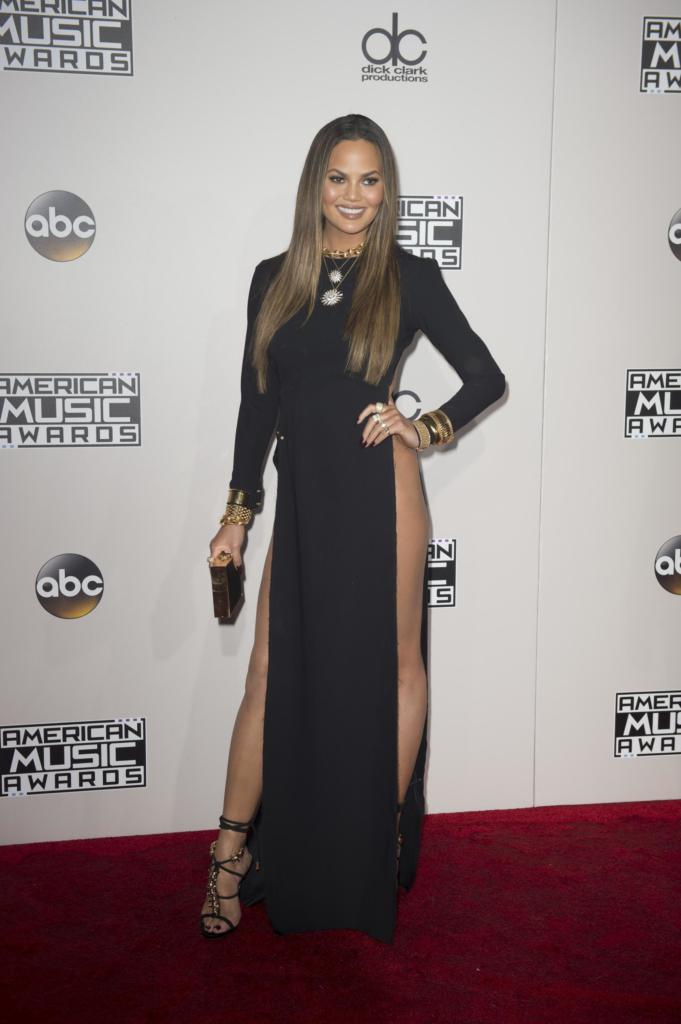

In [34]:
from IPython.display import Image,display_jpeg
display_jpeg(Image('./data/ifashionist-dataset/train/4789aab7dffdf2ebe4ea809275df5e26.jpg'))

In [35]:
from IPython.display import Image,display_jpeg
display_jpeg(Image('output_image.jpg'))

In [36]:
%%bash
#export WEIGHTS=`ls weights/yolact_plus_resnet50_fashionpedia_0_*.pth`
#
#python ./train.py --config=yolact_plus_resnet50_fashionpedia_config --resume=${WEIGHTS} --batch_size=4 --save_interval=500 --keep_latest

MAX=1000
for ((i=0; i < $MAX; i++)); do
    export WEIGHTS=`ls weights/yolact_plus_resnet50_fashionpedia_*.pth`
    echo ${WEIGHTS}
    #python ./train.py --config=yolact_plus_resnet50_fashionpedia_config --resume=${WEIGHTS} --batch_size=4 --save_interval=500 --keep_latest
    #python ./train.py --config=yolact_plus_resnet50_fashionpedia_config --resume=${WEIGHTS} --batch_size=4 --save_interval=100 --keep_latest
    python ./train.py --config=yolact_plus_resnet50_fashionpedia_config --resume=${WEIGHTS} --batch_size=4 --save_interval=500 --keep_latest
done


Scaling parameters by 0.50 to account for a batch size of 4.
Per-GPU batch size is less than the recommended limit for batch norm. Disabling batch norm.
loading annotations into memory...
Done (t=7.14s)
creating index...
index created!
loading annotations into memory...
Done (t=0.15s)
creating index...
index created!
Resuming training, loading ...

Scaling parameters by 0.50 to account for a batch size of 4.
Per-GPU batch size is less than the recommended limit for batch norm. Disabling batch norm.
loading annotations into memory...
Done (t=6.98s)
creating index...
index created!
loading annotations into memory...
Done (t=0.15s)
creating index...
index created!
Resuming training, loading ...

Scaling parameters by 0.50 to account for a batch size of 4.
Per-GPU batch size is less than the recommended limit for batch norm. Disabling batch norm.
loading annotations into memory...
Done (t=6.99s)
creating index...
index created!
loading annotations into memory...
Done (t=0.15s)
creating in

ls: cannot access 'weights/yolact_plus_resnet50_fashionpedia_*.pth': No such file or directory
Traceback (most recent call last):
  File "./train.py", line 504, in <module>
    train()
  File "./train.py", line 207, in train
    yolact_net.load_weights(args.resume)
  File "/content/yolact/yolact.py", line 479, in load_weights
    state_dict = torch.load(path)
  File "/usr/local/lib/python3.6/dist-packages/torch/serialization.py", line 525, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/usr/local/lib/python3.6/dist-packages/torch/serialization.py", line 212, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/usr/local/lib/python3.6/dist-packages/torch/serialization.py", line 193, in __init__
    super(_open_file, self).__init__(open(name, mode))
FileNotFoundError: [Errno 2] No such file or directory: ''
ls: cannot access 'weights/yolact_plus_resnet50_fashionpedia_*.pth': No such file or directory
Traceback (most recent call last):
  File "./train

# Conclusion
🎉 Woohoo! You did it! 🎉

Thanks for checking out the notebook, I hope it was helpful!

**If you liked it, consider sharing it!** YOLACT is pretty awesome, so more people should know about it.


### Want to learn how to Train on a custom dataset?

Check out this tutorial:

[Train YOLACT with a Custom COCO Dataset | Immersive Limit](https://www.immersivelimit.com/tutorials/train-yolact-with-a-custom-coco-dataset)